# Vehicle Routing

## The Introduction

Logistics is a major industry, with some estimates valuing it at USD 8183 billion globally in 2015. Most service providers operate a number of vehicles (e.g., trucks and container ships), a number of depots, where the vehicles are based overnight, and serve a number of client locations with each vehicle during each day. There are many optimization and control problems that consider these parameters. Computationally, the key challenge is how to design routes from depots to a number of client locations and back to the depot, so as to minimize vehicle-miles traveled, time spent, or similar objective functions. In this notebook we formalize an idealized version of the problem and showcase its solution using the quantum approximate optimization approach of Farhi, Goldstone, and Gutmann (2014). 

The overall workflow we demonstrate comprises:

1. establish the client locations. Normally, these would be available ahead of the day of deliveries from a database. In our use case, we generate these randomly.

2. compute the pair-wise distances, travel times, or similar. In our case, we consider the Euclidean distance, "as the crow flies", which is perhaps the simplest possible.

3. compute the actual routes. This step is run twice, actually. First, we obtain a reference value by a run of a classical solver (IBM CPLEX) on the classical computer. Second, we run an alternative, hybrid algorithm partly on the quantum computer.

4. visualization of the results. In our case, this is again a simplistic plot.

In the following, we first explain the model, before we proceed with the installation of the pre-requisites and the data loading.

## The Model 

Mathematically speaking, the vehicle routing problem (VRP) is a combinatorial problem, wherein the best routes from a depot to a number of clients and back to the depot are sought, given a number of available vehicles. 

Let $N_0$ be the number of clients (indexed as $1,\dots,N_0$), and $V$ be the number of available vehicles. Let $y_{i,\alpha} = \{0,1\}$ be the binary decision variable which, if it is $1$, activates the node $i$ in order $\alpha$ of the cyclic route. The node index $i$ runs from $0$ to $N_0$, where $0$ is (by convention) the depot and the order $\alpha$ runs from $1$ to $N_0$. The route starts and ends back at the depot so we do not include variables $y_{0,0}$ and $y_{0,N_0+1}$ in the cost function, as they are automatically set equal to 1 via the other constraints that we use for the depot. In fact, we end up not using the depot variables ($y_{0,\alpha}$) at all. Hence, there are $N_0^2$ decision variables, as we have assumed a fully connected graph. $c_{i,j}$ is the variable cost of travelling from node $i$ to node $j$ and $t$ is the fixed cost of operating each vehicle (=fixed cost of each vehicle leaving the depot).

The VRP can be formulated as:

$$
(VRP) \quad  f = \min_{\{y_{i,\alpha}\}_{i, \alpha}\in \{0,1\}} \sum_{i, j} c_{i,j} \sum_{\alpha=1}^{N_0-1} y_{i,\alpha}y_{j,\alpha+1} 
+ \sum_{i=1}^{N_0} c_{0,i} \bigg[ y_{i,1} + \sum_{\alpha=2}^{N_0} \bigg( 1 - \sum_{\substack{j=1\\ j\neq i}}^{N_0} y_{j,\alpha-1} \bigg) y_{i,\alpha} \bigg]
+ \sum_{i=1}^{N_0} c_{i,0} \bigg[ y_{i,N_0} + \sum_{\alpha=1}^{N_0-1} \bigg( 1 - \sum_{\substack{j=1\\ j\neq i}}^{N_0} y_{j,\alpha+1} \bigg) y_{i,\alpha} \bigg] \\
+ t \sum_{j=1}^{N_0}\sum_{\alpha=2}^{N_0} \bigg( 1 - \sum_{i=1}^{N_0} y_{i,\alpha-1} \bigg) y_{j,\alpha}
$$

subject to the node-visiting constraints:

$$
\sum_{\alpha=1}^{N_0} y_{i,\alpha} = 1, \,\sum_{i=1}^{N_0} y_{i,\alpha} = 1,\, \forall i,\alpha \in \{1,\dots,N_0\},
$$

which can be added to the cost function using the following terms:

$$
\sum_{i=1}^{N_0}\bigg( 1 - \sum_{\alpha=1}^{N_0} y_{i,\alpha} \bigg)^2
$$

and 

$$
\sum_{\alpha=1}^{N_0}\bigg( 1 - \sum_{i=1}^{N_0} y_{i,\alpha} \bigg)^2,
$$

respectively.


## Classical solution

We can solve the VRP classically, e.g., by using CPLEX. CPLEX uses a branch-and-bound-and-cut method to find an approximate solution of the VRP, which, in this formulation, is a mixed-integer linear program (MILP). For the sake of notation, we pack the decision variables in one vector as

$$
{\bf z} = [y_{11},y_{12},\ldots,y_{21}, y_{22},\ldots,y_{N_0,N_0}]^T,
$$

wherein ${\bf z} \in \{0,1\}^{n}$, with $n = N_0^2$. So the dimension of the problem scales quadratically with the number of nodes. Let us denote the optimal solution by ${\bf z}^*$, and the associated optimal cost $f^*$. 


## Quantum solution

Here, we demonstrate an approach that combines classical and quantum computing steps, following the quantum approximate optimization approach of Farhi, Goldstone, and Gutmann (2014). In particular, we use the variational quantum eigensolver (VQE). We stress that given the use of limited depth of the quantum circuits employed (variational forms), it is hard to discuss the speed-up of the algorithm, as the solution obtained is heuristic in nature. At the same time, due to the nature and importance of the target problems, it is worth investigating heuristic approaches, which may be worthwhile for some problem classes. 

The algorithm can be summarized as follows:

- Preparation steps: 
	- Transform the combinatorial problem into a binary polynomial optimization problem with equality constraints only;
	- Map the resulting problem into an Ising Hamiltonian ($H$) for variables ${\bf z}$ and basis $Z$, via penalty methods if necessary;
	- Choose the depth of the quantum circuit $m$. Note that the depth can be modified adaptively.
	- Choose a set of controls $\theta$ and make a trial function $\big|\psi(\boldsymbol\theta)\rangle$, built using a quantum circuit made of C-Phase gates and single-qubit Y rotations, parameterized by the components of $\boldsymbol\theta$.


- Algorithm steps: 
	- Evaluate $C(\boldsymbol\theta) = \langle\psi(\boldsymbol\theta)\big|H\big|\psi(\boldsymbol\theta)\rangle$ by sampling the outcome of the circuit in the Z-basis and adding the expectation values of the individual Ising terms together. In general, different control points around $\boldsymbol\theta$ have to be estimated, depending on the classical optimizer chosen.
	- Use a classical optimizer to choose a new set of controls.
	- Continue until $C(\boldsymbol\theta)$ reaches a minimum, close enough to the solution $\boldsymbol\theta^*$.
	- Use the last $\boldsymbol\theta$ to generate a final set of samples from the distribution $\Big|\langle z_i\big|\psi(\boldsymbol\theta)\rangle\Big|^2\;\forall i$ to obtain the answer.


There are many parameters throughout, notably the choice of the trial wavefunction. Below, we consider:

$$
\big|\psi(\theta)\rangle = [U_\mathrm{single}(\boldsymbol\theta) U_\mathrm{entangler}]^m \big|+\rangle
$$

where $U_\mathrm{entangler}$ is a collection of C-Phase gates (fully-entangling gates), and $U_\mathrm{single}(\theta) = \prod_{i=1}^N Y(\theta_{i})$, where $N$ is the number of qubits and $m$ is the depth of the quantum circuit. 


### Construct the Ising Hamiltonian

From $VRP$ one can construct a binary polynomial optimization with equality constraints only by considering cases in which $V=N_0-1$. In these cases the sub-tour elimination constraints are not necessary and the problem is only on the variable ${\bf z}$. In particular, we can write an augmented Lagrangian as

$$
(IH) \quad H = A\sum_{i, j} c_{i,j} \sum_{\alpha=1}^{N_0-1} y_{i,\alpha}y_{j,\alpha+1} 
+ A\sum_{i=1}^{N_0} c_{0,i} \bigg[ y_{i,1} + \sum_{\alpha=2}^{N_0} \bigg( 1 - \sum_{\substack{j=1\\ j\neq i}}^{N_0} y_{j,\alpha-1} \bigg) y_{i,\alpha} \bigg]
+ A\sum_{i=1}^{N_0} c_{i,0} \bigg[ y_{i,N_0} + \sum_{\alpha=1}^{N_0-1} \bigg( 1 - \sum_{\substack{j=1\\ j\neq i}}^{N_0} y_{j,\alpha+1} \bigg) y_{i,\alpha} \bigg] \\
+ B t \sum_{j=1}^{N_0}\sum_{\alpha=2}^{N_0} \bigg( 1 - \sum_{i=1}^{N_0} y_{i,\alpha-1} \bigg) y_{j,\alpha}
+ C \sum_{i=1}^{N_0}\bigg( 1 - \sum_{\alpha=1}^{N_0} y_{i,\alpha} \bigg)^2
+ D \sum_{\alpha=1}^{N_0}\bigg( 1 - \sum_{i=1}^{N_0} y_{i,\alpha} \bigg)^2,
$$

where $C,D$ are a big enough parameters such that the constraints are not violated. 

### From Hamiltonian to QP formulation 

In the vector ${\bf z}$, and for a complete graph ($\delta(i)^+ = \delta(i)^- = \{0,1,\dots,i-1,i+1,\dots,n\}$), $H$ can be written as follows.


$$
\min_{\bf z\in \{0,1\}^{n(n+1)}} \bf z^T {\bf Q} \bf z + {\bf g}^T \bf z + c,
$$

The QP formulation of the Ising Hamiltonian is ready for the use of VQE. We will solve the QP using optimization stack available in Qiskit.



## References

[1] E. Farhi, J. Goldstone, S. Gutmann e-print arXiv 1411.4028, 2014

[2] [Max-Cut and Traveling Salesman Problem](./06_examples_max_cut_and_tsp.ipynb)

[3] C. E. Miller, E. W. Tucker, and R. A. Zemlin (1960). "Integer Programming Formulations and Travelling Salesman Problems". J. ACM. 7: 326–329. doi:10.1145/321043.321046.

[4] D. L. Applegate, R. M. Bixby, V. Chvátal, and W. J. Cook (2006). The Traveling Salesman Problem. Princeton University Press, ISBN 978-0-691-12993-8.

## Initialization

First of all we load all the packages that we need.
CPLEX is required for the classical computations. You can install it by `pip install 'qiskit-optimization[cplex]'`. 

In [10]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import cplex
    from cplex.exceptions import CplexError
except:
    print("Warning: Cplex not found.")
import math

from qiskit.utils import algorithm_globals
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Sampler

We then initialize the variables

In [11]:
# Initialize the problem by defining the parameters
n = 5  # number of nodes + depot (n+1)
K = 2  # number of vehicles
t_list = 10 * np.array([2,5]) #np.random.random(K)  # fixed cost of running each vehicle

We define an initializer class that randomly places the nodes in a 2-D plane and computes the distance between them. 

In [12]:
# Get the data
class Initializer:
    def __init__(self, n, K):
        self.n = n
        self.K = K

    def generate_instance(self):  # cost of travel

        n = self.n
        K = self.K

        # np.random.seed(33)
        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n]) #, K
        #for iv in range(0, K):
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = ((xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2) #* t_list[iv]/10
                instance[jj, ii] = instance[ii, jj] 

        return xc, yc, instance

In [13]:
# Initialize the problem by randomly generating the instance
initializer = Initializer(n+1, K)  # +1 for depot
xc, yc, instance = initializer.generate_instance()


In [22]:
xc

array([ 0.51003914,  2.55963937, -0.64283509, -4.57068577,  2.98724481,
       -2.72584275])

## Quantum solution from the ground up

For the quantum solution, we use Qiskit. 

First, we derive the solution from the ground up, using a class QuantumOptimizer that encodes the quantum approach to solve the problem and then we instantiate it and solve it. We define the following methods inside the class:

- `binary_representation` : encodes the problem $(M)$ into a QP terms (that's basically linear algebra);
- `construct_problem` : constructs a QUBO optimization problem as an instance of `QuadraticProgram`;
- `solve_problem`: solves the problem $(M)$ constructed at the previous step via `MinimunEigenOptimizer` by using `SamplingVQE` with default parameters;

In [14]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.algorithms import CplexOptimizer


class GenOptimizer:
    def __init__(self, instance, t_vec, n, K):

        self.instance = instance
        self.t_vec = t_vec
        self.n = n
        self.K = K

    def binary_representation(self, x_sol=0):

        instance = self.instance
        t_vec = self.t_vec
        n = self.n
        K = self.K

        C_D = np.max(instance) * 2.0  # A parameter of cost function
        
        # a: 1..n
        # i,j: 1...n

        # Determine the vars        
        
        cij = instance[1:,1:] # cost b/w ij nodes (not incl depot)
        ci0_vec = instance[1:,0]
        c0i_vec = instance[0,1:]
        
        # term 1 (quad)
        cij_sym = (cij+cij.T)/2
        M1a = np.zeros((n,n))
        M1a[:-1,1:] = np.identity(n-1)
        M1 = np.kron(cij_sym,M1a)
        
        # term 2
        
        # 21 (linear)
        alpha_ones = np.ones(n)
        V21ia = np.kron(c0i_vec,alpha_ones)
        
        id_i = np.identity(n)
        M21a = np.zeros((n,n))
        M21a[0,0] = 1
        M21ia = np.kron(id_i,M21a)
        
        V21 = (V21ia.T)@M21ia
        
        # term 22 (linear)
        
        alpha_0_ones = np.ones(n)
        alpha_0_ones[0] = 0
        V22 = np.kron(c0i_vec,alpha_0_ones)
        
        # term 23 (quad)
        
        c0i_row, c0i_col = np.meshgrid(c0i_vec, c0i_vec, indexing='ij')
        c0i_arr = c0i_col - np.diag(c0i_vec)
        M23a = np.zeros((n,n))
        M23a[1:,:-1] = np.identity(n-1)
        
        M23 = -np.kron(c0i_arr,M23a)
        
        # term 31 (linear)
        
        alpha_ones = np.ones(n)
        V31ia = np.kron(ci0_vec,alpha_ones)
        
        id_i = np.identity(n)
        M31a = np.zeros((n,n))
        M31a[-1,-1] = 1
        M31ia = np.kron(id_i,M31a)
        
        V31 = (V31ia.T)@M31ia
        
        # term 32 (linear)
        
        alpha_ones_0 = np.ones(n)
        alpha_ones_0[-1] = 0
        V32 = np.kron(ci0_vec,alpha_ones_0)
        
        # term 33 (quad)
        
        ci0_row, ci0_col = np.meshgrid(ci0_vec, ci0_vec, indexing='ij')
        ci0_arr = ci0_col - np.diag(ci0_vec)
        M33a = np.zeros((n,n))
        M33a[:-1,1:] = np.identity(n-1)
        M33 = -np.kron(ci0_arr,M33a)
        
        # term 41 (linear)
        
        alpha_0_ones = np.ones(n)
        alpha_0_ones[0] = 0
        i_ones = np.ones(n)
        V41 = np.kron(np.kron(i_ones,alpha_0_ones),t_vec)
        
        # term 42 (quad)
        
        t_val_arr = np.diag(t_vec)
        
        i_ones_arr = np.ones((n,n))
        M42a = np.zeros((n,n))
        M42a[1:,:-1] = np.identity(n-1)
        M42 = - np.kron(np.kron(i_ones_arr,M42a),t_val_arr)
        
        # term 51 (linear+constant)
        
        V51 = -2 * np.ones(n ** 2)
        C51 = n
        
        # term 52 (quad)
        
        id_i = np.identity(n)
        M52a = np.ones((n,n))
        M52 = np.kron(id_i,M52a)
        
        # term 61 (linear+constant)
        
        V61 = -2 * np.ones(n ** 2)
        C61 = n
        
        # term 62 (quad)
        
        id_a = np.identity(n)
        M62i = np.ones((n,n))
        M62 = np.kron(M62i,id_a)
        
        # include vehicle index for quadratic terms of 1-4 (overall tensor product with identity)
        id_v = np.identity(K)
        
        M1 = np.kron(M1, id_v)
        M23 = np.kron(M23, id_v)
        M33 = np.kron(M33, id_v)
        #M42 = np.kron(M42, id_v)
        
        # include vehicle index for linear terms of 1-4 (overall tensor product with ones)
        
        ones_v = np.ones(K)
        
        V21 = np.kron(V21, ones_v)
        V22 = np.kron(V22, ones_v)
        V31 = np.kron(V31, ones_v)
        V32 = np.kron(V32, ones_v)
        #V41 = np.kron(V41, ones_v)
        
        # include vehicle index for linear terms of 5-6 (overall tensor product with ones)
        
        ones_v = np.ones(K)
        
        V51 = np.kron(V51, ones_v)
        V61 = np.kron(V61, ones_v)
        
        # include vehicle index for quadratic terms of 5-6 (overall tensor product with matrix of ones)
        
        ones_mat_v = np.ones((K,K))
        
        M52 = np.kron(M52, ones_mat_v)
        M62 = np.kron(M62, ones_mat_v)
        
        # constant terms remain unchanged
        
        # Q defines the interactions between variables: quadratic term
        Q = M1 + M23 + M33 + M42 + C_D * (M52 + M62)

        # g defines the contribution from the individual variables: linear term
        g = V21 + V22 + V31 + V32 + V41 + C_D * (V51 + V61)

        # c is the constant offset
        c = C_D * (C51 + C61)

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = (
                lambda x: np.dot(np.around(x), np.dot(Q, np.around(x)))
                + np.dot(g, np.around(x))
                + c
            )
            cost = fun(x_sol)
        except:
            cost = 0

        return Q, g, c, cost

    def construct_problem(self, Q, g, c) -> QuadraticProgram:
        qp = QuadraticProgram()
        for i in range(n * n * K):
            qp.binary_var(str(i))
        qp.objective.quadratic = Q
        qp.objective.linear = g
        qp.objective.constant = c
        return qp

    def solve_problem_quantum(self, qp):
        algorithm_globals.random_seed = 21 #37 #10598
        vqe = SamplingVQE(sampler=Sampler(), optimizer=SPSA(), ansatz=RealAmplitudes())
        optimizer = MinimumEigenOptimizer(min_eigen_solver=vqe)
        result = optimizer.solve(qp)
        # compute cost of the obtained result
        _, _, _, level = self.binary_representation(x_sol=result.x)
        return result.x, level
    
    def solve_problem_classical(self, qp):
        algorithm_globals.random_seed = 37 #10598
        vqe = SamplingVQE(sampler=Sampler(), optimizer=SPSA(), ansatz=RealAmplitudes())
        optimizer = CplexOptimizer() 
        result = optimizer.solve(qp)
        # compute cost of the obtained result
        _, _, _, level = self.binary_representation(x_sol=result.x)
        return result.x, level

### Step 1

Instantiate the quantum optimizer class with parameters: 

- the instance;
- the number of nodes and vehicles `n` and `K`;

In [15]:
# Instantiate the quantum optimizer class with parameters:
quantum_optimizer = GenOptimizer(instance, t_list, n, K)

### Step 2

Encode the problem as a binary formulation (IH-QP).

Sanity check: make sure that the binary formulation in the quantum optimizer is correct (i.e., yields the same cost given the same solution).

### Step 3

Encode the problem as an instance of `QuadraticProgram`.

In [16]:
Q, g, c, binary_cost = quantum_optimizer.binary_representation()
qp = quantum_optimizer.construct_problem(Q, g, c)

### Step 4

Solve the problem via `MinimumEigenOptimizer` from the optimization stack. N.B. Depending on the number of qubits, the state-vector simulation can take a while; for example with 12 qubits, it takes more than 12 hours. Logging is useful to see what the program is doing.

In [17]:
#quantum_solution, quantum_cost = quantum_optimizer.solve_problem_quantum(qp)
classical_solution, classical_cost = quantum_optimizer.solve_problem_classical(qp)

#print(quantum_solution, quantum_cost)
print(classical_solution, classical_cost)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0.] 50.033924266599115


### Step 5
Visualize the solution

In [18]:
# Visualize the solution

import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt

def visualize_solution(xc, yc, x_flat, C, n, K, title_str):
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color="r")
    plt.plot(xc[0], yc[0], "r*", ms=20)

    plt.grid()
    
    cmap = plt.cm.jet

    cNorm  = colors.Normalize(vmin=1, vmax=K)

    scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)
   
    cb = plt.colorbar(scalarMap, ax = ax, pad=.025)

    cb.ax.set_title(r'K')

   
    x_arr = np.reshape(x_flat, ((n+1)**2, K))
    for iv in range(0, K):
        x = x_arr[:,iv]
        colorVal = scalarMap.to_rgba(iv+1)
        for ii in range(0, (n+1)**2):

            if x[ii] > 0:
                ix = ii // (n+1)
                iy = ii % (n+1)
                plt.arrow(
                    xc[ix],
                    yc[ix],
                    xc[iy] - xc[ix],
                    yc[iy] - yc[ix],
                    length_includes_head=True,
                    head_width=0.25,
                    color=colorVal
                )

    plt.title(title_str + " cost = " + str(int(C * 100) / 100.0))
    plt.show()



In [19]:

def f_y_to_x(sol):

    x_ij_temp = np.zeros((n, n, K))  # xij, not incl depot

    y_i_alpha = np.reshape(sol, (n,n,K))

    for i in range(0, n):
        for j in range(0, n):
            for a in range(0, n-1):
                x_ij_temp[i,j,:] += y_i_alpha[i,a,:] * y_i_alpha[j,a+1,:]

    x_ij_full = np.zeros((n+1, n+1, K))

    x_ij_full[1:,1:,:] = x_ij_temp

    for i in range(0, n):
        x_ij_full[0,i+1] += y_i_alpha[i,0]
        for a in range(1, n):
            x_ij_full[0,i+1] += y_i_alpha[i,a]
            for j in range(0, n):
                if j!=i:
                    x_ij_full[0,i+1,:] += -y_i_alpha[j,a-1,:] * y_i_alpha[i,a,:]

    for i in range(0, n):
        x_ij_full[i+1,0,:] += y_i_alpha[i,-1,:]
        for a in range(0, n-1):
            x_ij_full[i+1,0,:] += y_i_alpha[i,a,:]
            for j in range(0, n):
                if j!=i:
                    x_ij_full[i+1,0,:] += -y_i_alpha[j,a+1,:] * y_i_alpha[i,a,:]
                    
    return x_ij_full


In [20]:
t_list

array([20, 50])

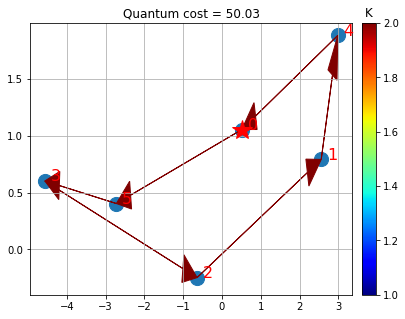

In [21]:
# Put the solution in a way that is compatible with the classical variables

# change y_i,alpha back to x_ij to plot

#x_ij_q = f_y_to_x(quantum_solution)
x_ij_c = f_y_to_x(classical_solution)

# visualize the solution
#visualize_solution(xc, yc, x_ij_q.flatten(), quantum_cost, n, K, "Quantum")

# and visualize the classical for comparison
visualize_solution(xc, yc, x_ij_c.flatten(), classical_cost, n, K, "Quantum")


The plots present the depot with a star and the selected routes for the vehicles with arrows. Note that in this particular case, we can find the optimal solution of the QP formulation, which happens to coincide with the optimal solution of the ILP.

Keep in mind that VQE is an heuristic working on the QP formulation of the Ising Hamiltonian, though. For suitable choices of A, local optima of the QP formulation will be feasible solutions to the ILP. While for some small instances, as above, we can find optimal solutions of the QP formulation which coincide with optima of the ILP, finding optimal solutions of the ILP is harder than finding local optima of the QP formulation, in general, which in turn is harder than finding feasible solutions of the ILP. Even within the VQE, one may provide stronger guarantees, for specific variational forms (trial wave functions). 

In [15]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright